In [1]:
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from xml.dom import minidom
import tqdm

In [2]:
audio_file = "data/audio/0gks6ceq4eQ.wav"
video_file = "data/video/0gks6ceq4eQ.mp4"
caption_file = "data/captions/0gks6ceq4eQ.csv"

In [3]:
captions = pd.read_csv(caption_file)
signal, sampling_rate = librosa.load(audio_file, sr=None)

In [4]:
fps = 10                                # Number of frames per second
window_size = sampling_rate // fps      # Number of samples per frame

duration = len(signal) / sampling_rate  # Duration in seconds
n_frames = np.round(duration * fps)     # Number of frames

In [5]:
mfccs = librosa.feature.mfcc(y=signal, sr=sampling_rate, n_mfcc=13, hop_length=window_size, n_fft=10 * window_size)

In [6]:
mfccs_d1 = librosa.feature.delta(mfccs, order=1)
mfccs_d2 = librosa.feature.delta(mfccs, order=2)

In [7]:
mfccs.shape, mfccs_d1.shape, mfccs_d2.shape

((13, 11088), (13, 11088), (13, 11088))

In [8]:
print(f"Sampling rate: {sampling_rate}, Signal length: {len(signal)}")
print(f"Number of frames: {n_frames}, MFCC shape: {mfccs.shape}")

Sampling rate: 44100, Signal length: 48894976
Number of frames: 11087.0, MFCC shape: (13, 11088)


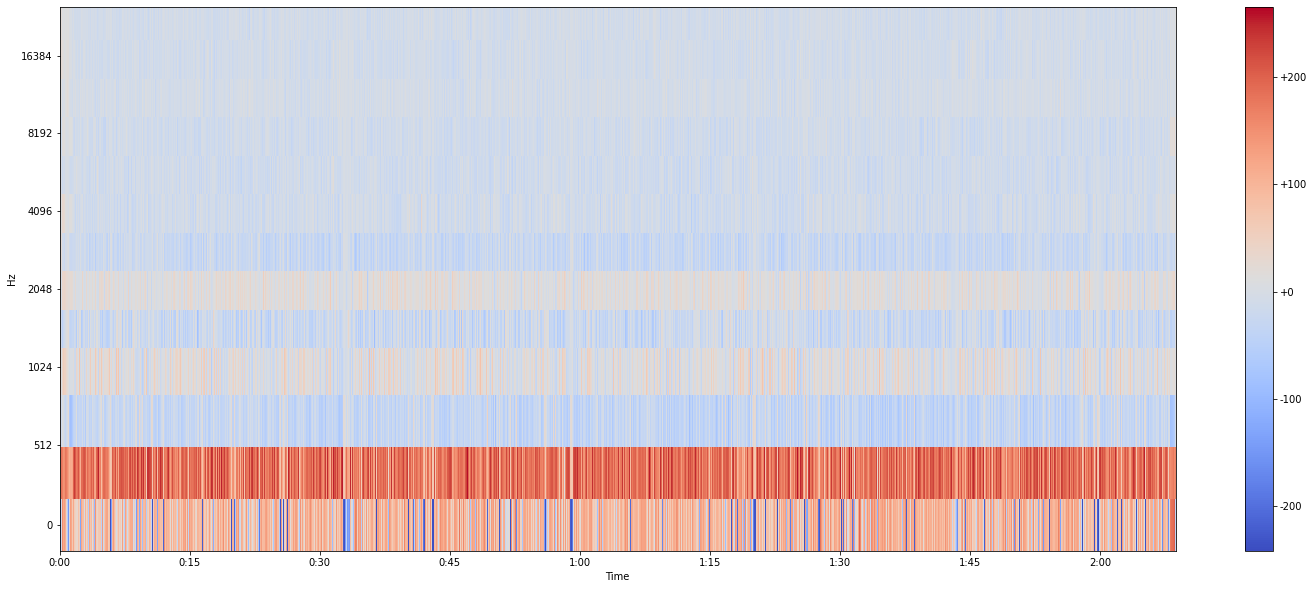

In [12]:
plt.figure(figsize=(25, 10))
librosa.display.specshow(mfccs, x_axis="time", y_axis="mel", sr=sampling_rate)
plt.colorbar(format="%+2.0f")
plt.show()

In [8]:
import cv2
import PIL
import mediapipe as mp

from google.protobuf.json_format import MessageToDict

In [15]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

model = mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.7, model_complexity=1)

def draw_hands(image, model, index=0):

    image = cv2.flip(image, 1)
    # Convert the BGR image to RGB before processing.
    results = model.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    if not results.multi_hand_landmarks:
        cv2.imwrite(f"tmp/annotated_image_{index}.png", cv2.flip(image, 1))
    else:
        annotated_image = image.copy()
        
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(
                annotated_image,
                hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                mp_drawing_styles.get_default_hand_landmarks_style(),
                mp_drawing_styles.get_default_hand_connections_style()
            )
        
        
        cv2.imwrite(f"tmp/annotated_image_{index}.png", cv2.flip(annotated_image, 1))
        

def decode_hand_landmarks(i, results):
    classification = MessageToDict(results.multi_handedness[i])["classification"][0]
    label = classification["label"]
    
    hand_landmarks = results.multi_hand_landmarks[i]

    X = []

    for j in range(len(hand_landmarks.landmark)):
        X.append([hand_landmarks.landmark[j].x, hand_landmarks.landmark[j].y, 1.0])
        
    X = np.array(X)
    T = np.identity(3)
    T[:2, 2] = -X[0, :2]
    
    x, y, _ = np.dot(T, X.T)
        
    return label, x, y


def fill_missing_frames(x):
    return pd.DataFrame(np.array(x)).fillna(method="ffill").fillna(method="bfill").to_numpy()


def get_images_for_caption(t, d, fps, video_file):
    start_ft = t * fps // 1000
    end_ft = (t + d) * fps // 1000

    cap = cv2.VideoCapture(video_file)
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_ft)

    images = []

    while(cap.isOpened()):
        frame_exists, curr_frame = cap.read()
        if frame_exists:
            current_frame_id = int(cap.get(cv2.CAP_PROP_POS_FRAMES) - 1)
            
            if current_frame_id >= end_ft:
                break
            
            images.append(curr_frame)
        else:
            break
    
    return images


def generate_keypoints(images, model, threshold=0.6):

    missed_frames = 0
    left_hand_landmarks_x = []
    left_hand_landmarks_y = []
    right_hand_landmarks_x = []
    right_hand_landmarks_y = []

    for i in range(len(images)):

        image = cv2.flip(images[i], 1)

        results = model.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        
        if not results.multi_hand_landmarks:
            missed_frames += 1
            left_hand_landmarks_x.append([np.nan] * 21)
            left_hand_landmarks_y.append([np.nan] * 21)
            right_hand_landmarks_x.append([np.nan] * 21)
            right_hand_landmarks_y.append([np.nan] * 21)
        elif len(results.multi_hand_landmarks) == 1:
            label, x, y = decode_hand_landmarks(0, results)
            missed_frames += 0.5
            if label == "Left":
                left_hand_landmarks_x.append(x)
                left_hand_landmarks_y.append(y)
                right_hand_landmarks_x.append([np.nan] * 21)
                right_hand_landmarks_y.append([np.nan] * 21)
            else:
                left_hand_landmarks_x.append([np.nan] * 21)
                left_hand_landmarks_y.append([np.nan] * 21)
                right_hand_landmarks_x.append(x)
                right_hand_landmarks_y.append(y)
        else:
            pLabel = None
            for i in range(2):
                label, x, y = decode_hand_landmarks(i, results)
                if label == pLabel:
                    missed_frames += 0.5
                    if label == "Left":
                        right_hand_landmarks_x.append([np.nan] * 21)
                        right_hand_landmarks_y.append([np.nan] * 21)
                    else:
                        left_hand_landmarks_x.append([np.nan] * 21)
                        left_hand_landmarks_y.append([np.nan] * 21)
                else:
                    if label == "Left":
                        left_hand_landmarks_x.append(x)
                        left_hand_landmarks_y.append(y)
                    else:
                        right_hand_landmarks_x.append(x)
                        right_hand_landmarks_y.append(y)
                pLabel = label
                    
    ratio = missed_frames / len(images)
    
    if ratio < threshold:
        left_hand_landmarks_x = fill_missing_frames(left_hand_landmarks_x)
        left_hand_landmarks_y = fill_missing_frames(left_hand_landmarks_y)
        right_hand_landmarks_x = fill_missing_frames(right_hand_landmarks_x)
        right_hand_landmarks_y = fill_missing_frames(right_hand_landmarks_y)
        
        drm = np.sqrt(np.square(right_hand_landmarks_x[:, 9]) + np.square(right_hand_landmarks_y[:, 9]))
        drs = 0.3 / drm

        dlm = np.sqrt(np.square(left_hand_landmarks_x[:, 9]) + np.square(left_hand_landmarks_y[:, 9]))
        dls = 0.3 / dlm

        left_hand_landmarks_x = np.multiply(left_hand_landmarks_x, dls[:, np.newaxis])
        left_hand_landmarks_y = np.multiply(left_hand_landmarks_y, dls[:, np.newaxis])
        right_hand_landmarks_x = np.multiply(right_hand_landmarks_x, drs[:, np.newaxis])
        right_hand_landmarks_y = np.multiply(right_hand_landmarks_y, drs[:, np.newaxis])

        landmarks = np.concatenate((left_hand_landmarks_x, left_hand_landmarks_y, right_hand_landmarks_x, right_hand_landmarks_y), axis=1)
        
        return landmarks, True
    
    else:
        return None, False

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [16]:
t, d = captions.iloc[26, [0, 1]]

images = get_images_for_caption(t, d, fps, video_file)

landmarks, is_valid = generate_keypoints(images, model)

In [18]:
start_ft = t * fps // 1000
end_ft = (t + d) * fps // 1000

print(f"Start frame: {start_ft}, End frame: {end_ft}")

Start frame: 1036, End frame: 1076


In [45]:
indices = np.arange(start_ft - 30, end_ft + 30)
windows = np.lib.stride_tricks.sliding_window_view(indices, window_shape=61)
w = mfccs[:, windows]


In [53]:
w1 = w.transpose(1, 2, 0)[0]

print(w1.T - w[:, 0, :])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [183]:
for i in range(landmarks.shape[0]):
    
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))

    lx, ly, rx, ry = landmarks[i, :21], landmarks[i, 21:42], landmarks[i, 42:63], landmarks[i, 63:]                
    ax[0].plot(lx, ly, "o")
    ax[0].set_xlim(-1, 1)
    ax[0].set_ylim(-1, 1)
    
    ax[1].plot(rx, ry, "o")
    ax[1].set_xlim(-1, 1)
    ax[1].set_ylim(-1, 1)
    
    fig.savefig(f"tmp/hands_landmarks_1/img_{i:3d}.png")
    plt.close()

In [325]:
valid_samples = 0

for i in tqdm.notebook.trange(len(captions)):
    
    t, d = captions.iloc[i, [0, 1]]

    images = get_images_for_caption(t, d, fps, video_file)

    landmarks, is_valid = generate_keypoints(images, model)
    
    valid_samples = valid_samples + 1 if is_valid else valid_samples

  0%|          | 0/332 [00:00<?, ?it/s]

### Normalization with the distance to middle finger MCP

In [178]:
lx, ly, rx, ry = landmarks[:, :21], landmarks[:, 21:42], landmarks[:, 42:63], landmarks[:, 63:]         

drm = np.sqrt(np.square(rx[:, 9]) + np.square(ry[:, 9]))
drs = 0.3 / drm

dlm = np.sqrt(np.square(lx[:, 9]) + np.square(ly[:, 9]))
dls = 0.3 / dlm

lx = np.multiply(lx, dls[:, np.newaxis])
ly = np.multiply(ly, dls[:, np.newaxis])
rx = np.multiply(rx, drs[:, np.newaxis])
ry = np.multiply(ry, drs[:, np.newaxis])

for i in range(landmarks.shape[0]):
    
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))

    ax[0].plot(lx[i], ly[i], "o")
    ax[0].set_xlim(-1, 1)
    ax[0].set_ylim(-1, 1)
    
    ax[1].plot(rx[i], ry[i], "o")
    ax[1].set_xlim(-1, 1)
    ax[1].set_ylim(-1, 1)
    
    fig.savefig(f"tmp/hands_landmarks_1/img_{i:3d}.png")
    plt.close()

### Normalizing hands coordinates

In [154]:
lx[0].shape

(21,)

In [73]:
image = cv2.imread("data/hands_sample/hand_sample_3.jpeg")

image = cv2.flip(image, 1)

results = model.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))


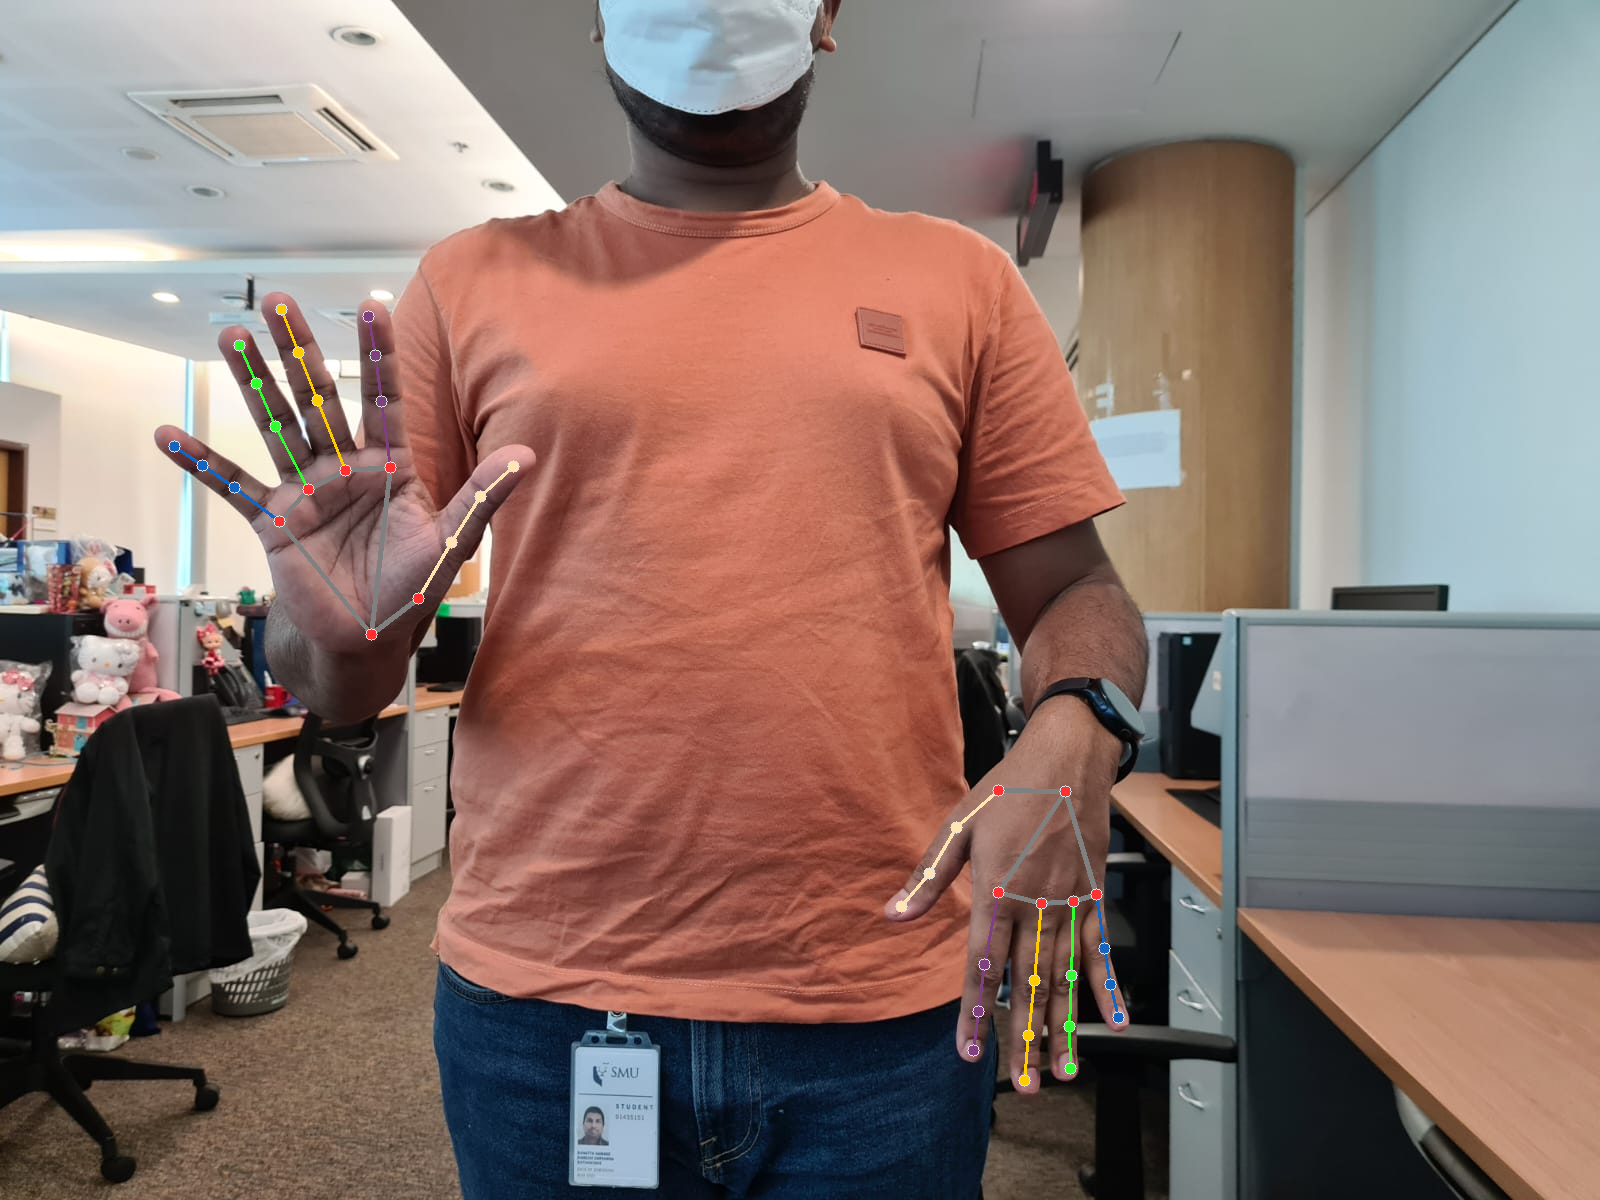

In [74]:
annotated_image = image.copy()
    
if results.multi_hand_landmarks:
    
    for hand_landmarks in results.multi_hand_landmarks:
        mp_drawing.draw_landmarks(
            annotated_image,
            hand_landmarks,
            mp_hands.HAND_CONNECTIONS,
            mp_drawing_styles.get_default_hand_landmarks_style(),
            mp_drawing_styles.get_default_hand_connections_style()
        )


PIL.Image.fromarray(annotated_image[:, ::-1, ::-1])


In [87]:
def decode_hand_landmarks(i, results):
    classification = MessageToDict(results.multi_handedness[i])["classification"][0]
    label = classification["label"]
    
    hand_landmarks = results.multi_hand_landmarks[i]

    X = []

    for j in range(len(hand_landmarks.landmark)):
        X.append([hand_landmarks.landmark[j].x, hand_landmarks.landmark[j].y, 1.0])
        
    X = np.array(X)
    T = np.identity(3)
    T[:2, 2] = -X[0, :2]
    
    x, y, _ = np.dot(T, X.T)
        
    return label, x, y

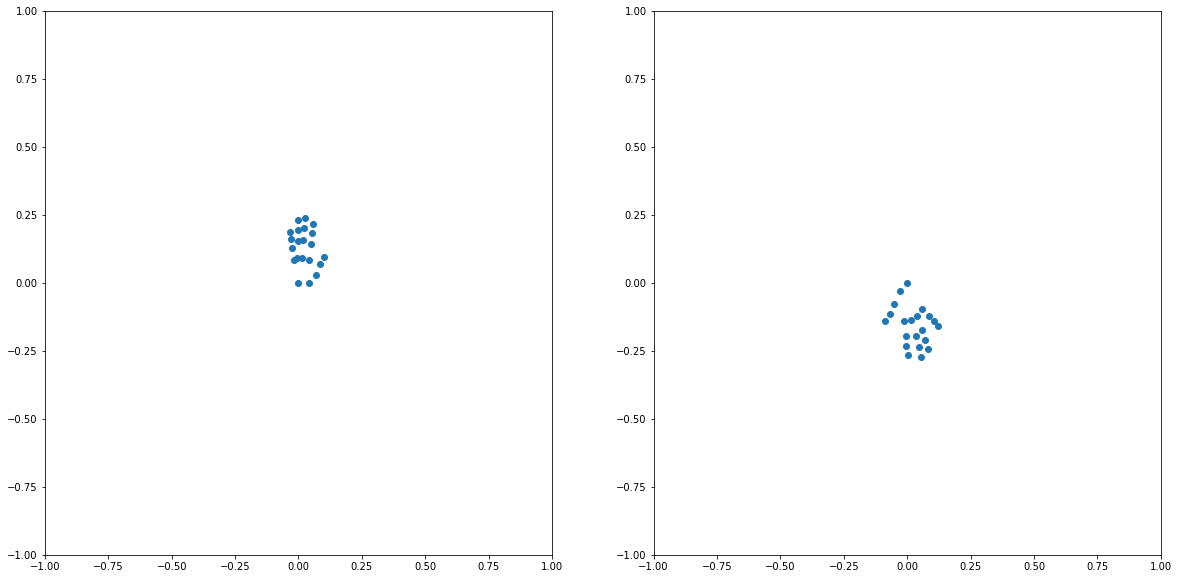

In [88]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

for i in range(2):
    label, x, y = decode_hand_landmarks(i, results)

    ax[i].plot(x, y, "o")
    ax[i].set_xlim(-1, 1)
    ax[i].set_ylim(-1, 1)

In [77]:
T = np.identity(3)

T[0, 2] = -x[0]
T[1, 2] = -y[0]

In [61]:
x, y, _ = np.dot(T, X.T)

In [170]:
arr = np.array([[np.nan, np.nan, np.nan],
                [1, 2, 3],
                [np.nan, np.nan, np.nan],
                [3, 4, 5],
                [5, 6, 7],
                [np.nan, np.nan, np.nan]])

array([[1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.],
       [3., 4., 5.],
       [5., 6., 7.],
       [5., 6., 7.]])